<span style='color:red'> NOTE: You can only pass the lab, when you provide both code and markdown </span>

Use Code for your analysis
Use Markdown to document and elaborate on your findings, conclusions, assertions, etc.

# DS_ML_I_P5: Classification of Image Data

## 5.1 Load the MNIST Data-Set
* get the data using code below
* assemble information on number of images, size of images, distribution among different classes

In [1]:
from sklearn.datasets import fetch_openml
from math import sqrt
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
# if we loaded the dataset using fetch_openml before, we can use the previously stored parquet file (which laods much faster)
preloaded = True

In [2]:
if preloaded == False:
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True)
    display(type(X), type(y))
else:
    %time df_mnist = pd.read_parquet("MNIST.parquet")
    X = df_mnist.iloc[:, 0:784]
    y = df_mnist.iloc[:, 784]

CPU times: total: 906 ms
Wall time: 233 ms


### Number of Images
The code try to look into sorted unique values of the class, which represent the type of images and count how many number of images exist within the dataset

In [3]:
existing_classes = df_mnist['class'].sort_values().unique()
print(f"There are {len(existing_classes)} different types of images")
print(f"They are { existing_classes}")


There are 10 different types of images
They are [0 1 2 3 4 5 6 7 8 9]


### Size of Images
As we can see below the there are columns for pixel1-pixel784, which means there are 784 pixels that represent an image.

In [4]:
df_pixels = df_mnist.drop(columns='class')
df_pixels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 418.7 MB


Show the calculation of an image based on the amount of pixels and bytes for each pixel

In [8]:
bytes_per_pixel = df_pixels.dtypes.iloc[0].itemsize
number_of_pixels = df_pixels.shape[1]
size_of_each_image = bytes_per_pixel * number_of_pixels

print(f"Each pixel is { bytes_per_pixel} bytes")
print(f"There are {number_of_pixels} pixels for one image")
print(f"The size of an image would be {bytes_per_pixel} * { 784} = {size_of_each_image}")

Each pixel is 8 bytes
There are 784 pixels for one image
The size of an image would be 8 * 784 = 6272


### Classes' Distribution
The code below counts the amount of each class and show the distribution the classses in a form of pie chart

In [18]:
class_counts = df_mnist['class'].value_counts().sort_index().reset_index()

fig = px.pie(
    class_counts,
    values='count',
    names='class',
    title='Distribution Among Different Classes',
)
fig.update_traces(sort=False ,textposition='inside', textinfo='percent+label+value')
fig.show()

## 5.2 Visualize the input data
* Display at least two images for each class in the dataset
* Show the class identity per image

To get an intuitive understanding of the dataset, we randomly sampled 2 images per class from the MNIST dataset and visualized them.

Each row below shows 2 example images for one digit class.

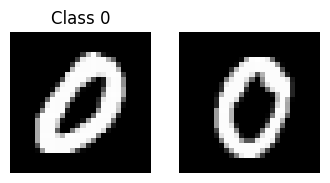

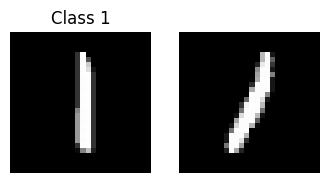

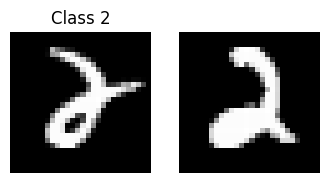

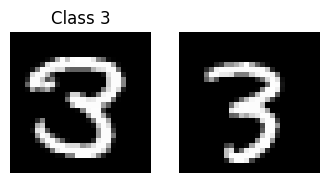

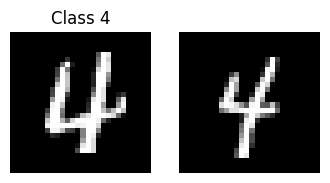

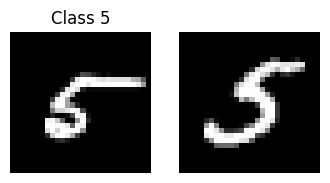

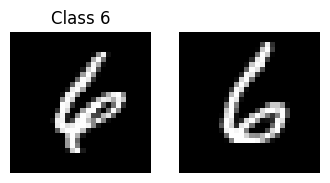

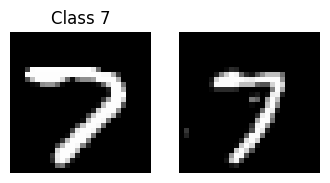

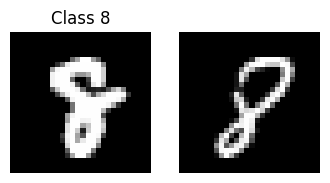

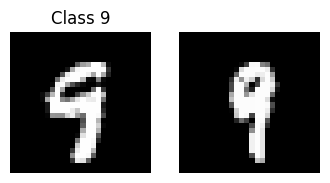

In [10]:
sampled_df = df_mnist.groupby('class').sample(n=2, random_state=42)

for cls in sampled_df['class'].unique():
    imgs = sampled_df[sampled_df['class'] == cls].drop('class', axis=1).values
    plt.figure(figsize=(4, 2))  # Width for 2 images, height small
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(imgs[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Class {cls}')
    plt.show()

## 5.3 Train a k-NN Classifier and Check the Performance

### 5.3.1 Import the required modules for classifier and performance measurement

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

### 5.3.2 Train the classifier using 3-fold cross_validation 
* create a training and testing set


For the sake of computation time and power of my own computer, a smaller stratified sample of dataset will be created

In [ ]:
X = df_mnist.drop(columns='class')
y = df_mnist['class']

X_sample, _, y_sample, _ = train_test_split(X,y, train_size=0.2, stratify=y, random_state=42)


We can see below that the distribution of the classes stays the same in the sampling, with a smaller number of sample than before. In total there are 14.000 entries compared to 60.000 before

In [23]:
df_sample = X_sample.copy()
df_sample['class'] = y_sample.values

class_counts = df_sample['class'].value_counts().sort_index().reset_index()

fig = px.pie(
    class_counts,
    values='count',
    names='class',
    title='Distribution Among Different Classes After Stratified Sampling',
)
fig.update_traces(sort=False ,textposition='inside', textinfo='percent+label+value')
fig.show()

print(f"Total rows in the dataset: {df_sample.shape[0]}")

Total rows in the dataset: 14000


Now the train and test set will be created from the small sample. It will be stratified to keep the distribution of the classes

In [24]:
X = df_sample.drop(columns='class')
y = df_sample['class']
# stratify=y ensures class balance in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=42, stratify=y)

* train the classifer with cross_validate, check the documentation: What does cross_validate return?


In [29]:
# Initialize KNN classifier with some custom parameters
knn = KNeighborsClassifier(
    n_neighbors=3,
    weights='distance',
)

# 3-fold cross-validation
cv_knn = cross_validate(
    knn,
    X_train, y_train,
    cv=3,
    scoring='accuracy',
)

It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.

Source: https://scikit-learn.org/stable/modules/cross_validation.html

In [30]:
cv_knn

{'fit_time': array([0.02238297, 0.03007579, 0.03066373]),
 'score_time': array([0.12119794, 0.09012127, 0.0837996 ]),
 'test_score': array([0.91541756, 0.89174705, 0.89389068])}

In [36]:
mean_score = np.mean(cv_knn['test_score'])
std_score = np.std(cv_knn['test_score'])

print(f"Mean accuracy: {mean_score:.4f}")
print(f"Standard deviation: {std_score:.4f}")

Mean accuracy: 0.9004
Standard deviation: 0.0107


Insights from Cross Validation of KNN:
1. KNN has negligible training time.
2. Scoring takes more time than fitting, typical for KNN.
3. Mean Accuracy ≈ 90.03% — Solid performance overall.
4. Low Std (≈ 1%) — Stable performance across folds (no major overfitting or data imbalance).

### 5.3.3 Use the best classifier from the previuous run and check with your test set
* Generate a classification report


In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Retrain the classifier on the full training set
best_knn = KNeighborsClassifier(
    n_neighbors=3,
    weights='distance'
)
best_knn.fit(X_train, y_train)

# 2. Predict on the test set
y_pred = best_knn.predict(X_test)

# 3. Generate and print the classification report
print("Classification Report of k-NN Classifier:")
print(classification_report(y_test, y_pred))


Classification Report of k-NN Classifier:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1105
           1       0.89      0.99      0.94      1260
           2       0.97      0.88      0.93      1118
           3       0.92      0.90      0.91      1143
           4       0.95      0.88      0.91      1092
           5       0.91      0.91      0.91      1010
           6       0.95      0.98      0.96      1100
           7       0.91      0.95      0.93      1166
           8       0.94      0.85      0.90      1092
           9       0.87      0.90      0.88      1114

    accuracy                           0.92     11200
   macro avg       0.93      0.92      0.92     11200
weighted avg       0.93      0.92      0.92     11200



The model achieves overall strong performance with a weighted F1-score of 0.92, indicating balanced precision and recall across most classes. However, classes 2, 4, and 9 show lower recall, meaning the model struggles to correctly identify all true instances of these classes. In contrast, class 1 shows very high recall but lower precision, suggesting it is often overpredicted.

* Generate a confusion matrix


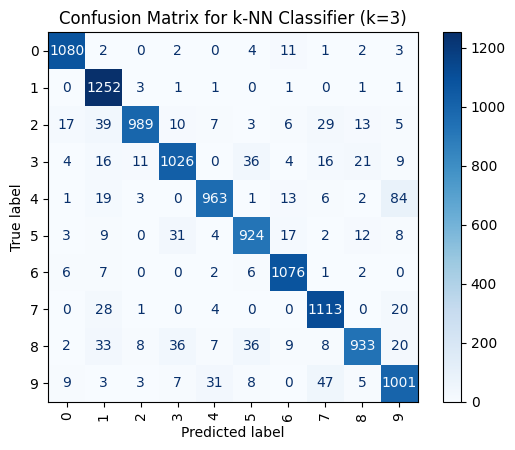

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix for k-NN Classifier (k=3)")
plt.show()

The confusion matrix reveals frequent misclassifications between specific class pairs, notably:

Class 2 → predicted as class 1 and 7,

Class 4 → confused with class 9,

Class 9 → confused with class 4 and 7.

These patterns suggest visual or feature similarity between these digits, which leads to the model's confusion and contributes to the lower recall and F1-scores for those classes.

# 5.4 Train a Decision Tree Classifier and Check the Performance

In [43]:
from sklearn.tree import DecisionTreeClassifier

### 5.4.1 Train the classifier using 3-fold cross_validation

In [45]:
dtc = DecisionTreeClassifier(
    random_state=42
)

cv_dtc = cross_validate(
    dtc,
    X_train,y_train,
    cv=3,
    scoring='accuracy',
)

Print and check the score

In [46]:
cv_dtc

{'fit_time': array([0.54708719, 0.39751673, 0.42502618]),
 'score_time': array([0.00819349, 0.01678801, 0.00790787]),
 'test_score': array([0.73768737, 0.69024652, 0.70203644])}

The cross-validation results show that the model performs fairly consistently, with accuracy scores ranging from about 69% to 74%. On average, the model gets things right around 71% of the time, and the variation between runs is small — so it's stable, just not highly accurate. The model also takes a bit longer to train, but prediction is fast.

### 5.4.2 Check the performance with your test set

Classification Report of Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1105
           1       0.85      0.89      0.87      1260
           2       0.74      0.67      0.70      1118
           3       0.67      0.66      0.66      1143
           4       0.76      0.71      0.73      1092
           5       0.59      0.63      0.61      1010
           6       0.78      0.73      0.75      1100
           7       0.78      0.84      0.81      1166
           8       0.66      0.62      0.64      1092
           9       0.68      0.74      0.71      1114

    accuracy                           0.74     11200
   macro avg       0.73      0.73      0.73     11200
weighted avg       0.74      0.74      0.73     11200



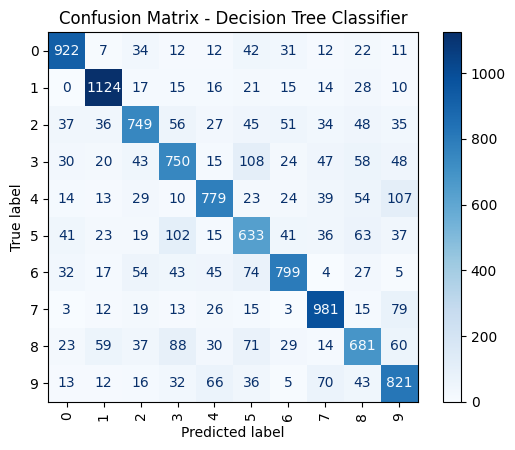

array([[ 922,    7,   34,   12,   12,   42,   31,   12,   22,   11],
       [   0, 1124,   17,   15,   16,   21,   15,   14,   28,   10],
       [  37,   36,  749,   56,   27,   45,   51,   34,   48,   35],
       [  30,   20,   43,  750,   15,  108,   24,   47,   58,   48],
       [  14,   13,   29,   10,  779,   23,   24,   39,   54,  107],
       [  41,   23,   19,  102,   15,  633,   41,   36,   63,   37],
       [  32,   17,   54,   43,   45,   74,  799,    4,   27,    5],
       [   3,   12,   19,   13,   26,   15,    3,  981,   15,   79],
       [  23,   59,   37,   88,   30,   71,   29,   14,  681,   60],
       [  13,   12,   16,   32,   66,   36,    5,   70,   43,  821]])

In [51]:
# 1. Retrain on the full training set
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

# 2. Predict on the test set
y_pred = dtc.predict(X_test)

# 3. Classification report
print("Classification Report of Decision Tree Classifier:")
print(classification_report(y_test, y_pred))

# 4. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Decision Tree Classifier")
plt.show()
cm

### Classification Report Insight

Looking at the detailed performance, the model does pretty well on some digits, especially 1, 0, and 7, where it gets most of them right. But it's noticeably weaker on digits like 5, 3, and 8, which are harder to distinguish — possibly because they share similar shapes. Overall, with an accuracy of 74%, it's doing a decent job, but there’s clearly room to improve, especially for those confusing classes.

### Confusion Matrix Insight

The confusion matrix gives us a clearer picture of where the model is struggling. For example:

* Digit 5 is often mistaken for 3 and 8
* Digit 4 is confused with 9
* Digit 8 gets mixed up with 3 and 5

This tells us the model has trouble telling apart some digits that might look visually similar or have overlapping features. It’s a common challenge with decision trees, since they don’t capture complex patterns as well as some other models.

## 5.5 Improve with random forests

In [52]:
from sklearn.ensemble import RandomForestClassifier

Train the random forest classifier and create classification report as well as confusion matrix

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1105
           1       0.95      0.98      0.97      1260
           2       0.92      0.90      0.91      1118
           3       0.92      0.89      0.90      1143
           4       0.93      0.93      0.93      1092
           5       0.93      0.90      0.92      1010
           6       0.95      0.97      0.96      1100
           7       0.93      0.94      0.94      1166
           8       0.90      0.89      0.90      1092
           9       0.90      0.91      0.90      1114

    accuracy                           0.93     11200
   macro avg       0.93      0.93      0.93     11200
weighted avg       0.93      0.93      0.93     11200



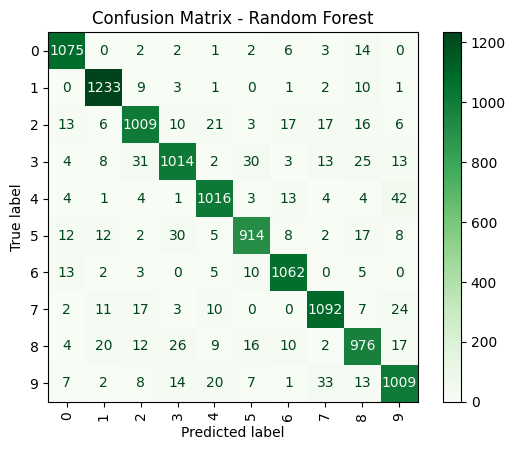

array([[1075,    0,    2,    2,    1,    2,    6,    3,   14,    0],
       [   0, 1233,    9,    3,    1,    0,    1,    2,   10,    1],
       [  13,    6, 1009,   10,   21,    3,   17,   17,   16,    6],
       [   4,    8,   31, 1014,    2,   30,    3,   13,   25,   13],
       [   4,    1,    4,    1, 1016,    3,   13,    4,    4,   42],
       [  12,   12,    2,   30,    5,  914,    8,    2,   17,    8],
       [  13,    2,    3,    0,    5,   10, 1062,    0,    5,    0],
       [   2,   11,   17,    3,   10,    0,    0, 1092,    7,   24],
       [   4,   20,   12,   26,    9,   16,   10,    2,  976,   17],
       [   7,    2,    8,   14,   20,    7,    1,   33,   13, 1009]])

In [54]:
rf = RandomForestClassifier(
    n_estimators=100,   
    random_state=42,
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens', xticks_rotation='vertical')
plt.title("Confusion Matrix - Random Forest")
plt.show()
cm

### Classification Report Insight (Random Forest)
The Random Forest model performs very well, reaching an overall accuracy of 93%. It shows balanced performance across all digit classes, with precision, recall, and F1-scores mostly in the 0.90–0.97 range. The model is particularly strong on digits like 0, 1, 6, and 7, which are predicted with very high accuracy. Even the more challenging digits like 3, 5, and 8 are handled effectively.

This indicates that the model is not only accurate but also consistently reliable across all categories, with minimal performance drop for any specific digit.

### Confusion Matrix Insight (Random Forest)
The confusion matrix confirms the strong performance:

Most digits are classified correctly, with only a few misclassifications scattered across classes.

For example, digit 3 is sometimes confused with 2, 5, and 8, while digit 4 occasionally gets mistaken for 9.

Still, these errors are relatively rare — usually fewer than 30–40 instances per class.

This tells us the Random Forest handles digit classification robustly, with very few systematic errors. Misclassifications appear to be minor and spread out, rather than concentrated in specific confusing class pairs — a good sign of model generalization.

## 5.6 Further improvement: Gradient Boosting (non Random) Forests

In [55]:
from sklearn.ensemble import GradientBoostingClassifier

A GradientBoostingClassifier was trained. The model was evaluated on the test set using a classification report and a confusion matrix.

In [ ]:
gb = GradientBoostingClassifier(
    n_estimators=100,      
    learning_rate=0.3,     
    max_depth=3,           
    random_state=42
)


In [77]:
gb.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.3, random_state=42)


📄 Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1105
           1       0.95      0.97      0.96      1260
           2       0.89      0.88      0.89      1118
           3       0.91      0.87      0.89      1143
           4       0.92      0.93      0.92      1092
           5       0.88      0.90      0.89      1010
           6       0.93      0.93      0.93      1100
           7       0.92      0.93      0.92      1166
           8       0.88      0.85      0.87      1092
           9       0.88      0.89      0.89      1114

    accuracy                           0.91     11200
   macro avg       0.91      0.91      0.91     11200
weighted avg       0.91      0.91      0.91     11200



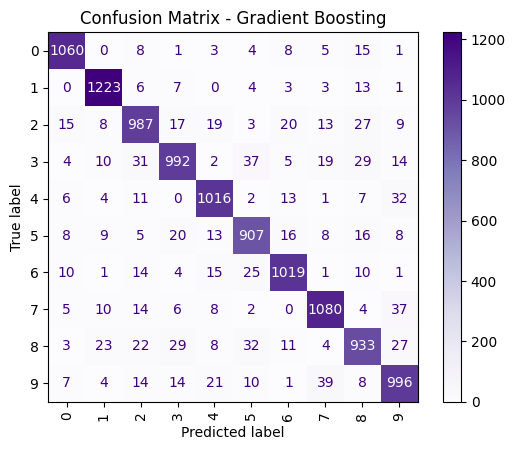

array([[1060,    0,    8,    1,    3,    4,    8,    5,   15,    1],
       [   0, 1223,    6,    7,    0,    4,    3,    3,   13,    1],
       [  15,    8,  987,   17,   19,    3,   20,   13,   27,    9],
       [   4,   10,   31,  992,    2,   37,    5,   19,   29,   14],
       [   6,    4,   11,    0, 1016,    2,   13,    1,    7,   32],
       [   8,    9,    5,   20,   13,  907,   16,    8,   16,    8],
       [  10,    1,   14,    4,   15,   25, 1019,    1,   10,    1],
       [   5,   10,   14,    6,    8,    2,    0, 1080,    4,   37],
       [   3,   23,   22,   29,    8,   32,   11,    4,  933,   27],
       [   7,    4,   14,   14,   21,   10,    1,   39,    8,  996]])

In [78]:
y_pred = gb.predict(X_test)

print("\n📄 Classification Report (Gradient Boosting):")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples', xticks_rotation='vertical')
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()
cm

### Classification Report Insight
Gradient Boosting is doing a solid job here with 91% accuracy. It handles most digits really well — especially 0, 1, and 4. Even the tougher ones like 3, 5, and 8 are predicted with good consistency. Overall, the model is balanced and performs reliably across all classes.

### Confusion Matrix Insight
Most predictions are spot-on, with only small mistakes between similar-looking digits like 3 and 5 or 8 and 9. The confusion is minimal, showing the model really understands the digit patterns.